In [1]:

import pyodbc    
from dotenv import dotenv_values
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ValueWarning

#libraries for handling data
import pandas as pd
import numpy as np 
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

# linear regression analysis
import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import pearsonr



In [2]:
# load environment variables from.env file into dictionary
environment_variables = dotenv_values(".env")
 
# get the values for the environment variables
server = environment_variables.get("server")
user = environment_variables.get("user")
password = environment_variables.get("password")
database = environment_variables.get("database")
 
# Create a database connection string using pyodbc
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={user};PWD={password}"

#Establish a connection to the database
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful")    
except Exception as e:
    print("Connection failed:", e)

Connection failed: ('08001', '[08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]SQL Server does not exist or access denied. (17) (SQLDriverConnect); [08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]ConnectionOpen (Connect()). (53)')


In [14]:
# cursor = connection.cursor()

# # Query to get all tables in the current database
# cursor.execute("""
#     SELECT TABLE_NAME
#     FROM INFORMATION_SCHEMA.TABLES
#     WHERE TABLE_TYPE = 'BASE TABLE'
# """)

# # Fetch and print the list of tables
# tables = cursor.fetchall()
# for table in tables:
#     print(table[0])


In [15]:
# Create a cursor object
cursor = connection.cursor()

# Query to get all table names in the database 
cursor.execute("""
    SELECT TABLE_NAME
    FROM INFORMATION_SCHEMA.TABLES
    WHERE TABLE_TYPE = 'BASE TABLE'
""")
tables = cursor.fetchall()

# Iterate through each table
for table in tables:
    table_name = table[0]
    print(f"Processing table: {table_name}")

    # Query to fetch all data from the table
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, connection)

    # Save the data to a CSV file
    csv_file = f"{table_name}.csv"
    df.to_csv(csv_file, index=False)
    print(f"Table {table_name} saved as {csv_file}")

Processing table: Sales_July_2019
Table Sales_July_2019 saved as Sales_July_2019.csv
Processing table: Sales_August_2019
Table Sales_August_2019 saved as Sales_August_2019.csv
Processing table: Sales_September_2019
Table Sales_September_2019 saved as Sales_September_2019.csv
Processing table: Sales_October_2019
Table Sales_October_2019 saved as Sales_October_2019.csv
Processing table: Sales_November_2019
Table Sales_November_2019 saved as Sales_November_2019.csv
Processing table: Sales_December_2019
Table Sales_December_2019 saved as Sales_December_2019.csv


In [3]:
# Information about the all 12 datasets, specifically to know the number of rows and columns in all of them 
# Directory where your CSV files are saved

directory = "data"

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Full file path
        file_path = os.path.join(directory, filename)
        
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Get the number of rows and columns
        rows, columns = df.shape
        
        # Print the results
        print(f"File: {filename}, Rows: {rows}, Columns: {columns}")


File: Sales_April_2019.csv, Rows: 18383, Columns: 6
File: Sales_August_2019.csv, Rows: 12011, Columns: 6
File: Sales_December_2019.csv, Rows: 25117, Columns: 6
File: Sales_February_2019.csv, Rows: 12036, Columns: 6
File: Sales_January_2019.csv, Rows: 9723, Columns: 6
File: Sales_July_2019.csv, Rows: 14371, Columns: 6
File: Sales_June_2019.csv, Rows: 13622, Columns: 6
File: Sales_March_2019.csv, Rows: 15226, Columns: 6
File: Sales_May_2019.csv, Rows: 16635, Columns: 6
File: Sales_November_2019.csv, Rows: 17661, Columns: 6
File: Sales_October_2019.csv, Rows: 20379, Columns: 6
File: Sales_September_2019.csv, Rows: 11686, Columns: 6


In [4]:
# information about the datatypes of columns in the various datasets

# List to store the data types for each dataset
data_types_dict = {}

# Assuming all files are stored in a folder
file_paths = glob.glob('data/*.csv')

# Loop through each file, read it into a DataFrame, and get the data types
for file in file_paths:
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Get the file name (optional, for reference)
        file_name = file.split('/')[-1]
        
        # Get the data types of the columns
        data_types = df.dtypes
        
        # Store the data types in a dictionary with the file name as key
        data_types_dict[file_name] = data_types
        
    except Exception as e:
        print(f"Error reading file {file}: {e}")

# Print the data types for each dataset in a structured format
for file_name, data_types in data_types_dict.items():
    print(f"Data types for {file_name}:\n")
    print(data_types)
    print("-" * 50)  # Separator for readability


Data types for data\Sales_April_2019.csv:

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
dtype: object
--------------------------------------------------
Data types for data\Sales_August_2019.csv:

Order_ID            float64
Product              object
Quantity_Ordered    float64
Price_Each          float64
Order_Date           object
Purchase_Address     object
dtype: object
--------------------------------------------------
Data types for data\Sales_December_2019.csv:

Order_ID            float64
Product              object
Quantity_Ordered    float64
Price_Each          float64
Order_Date           object
Purchase_Address     object
dtype: object
--------------------------------------------------
Data types for data\Sales_February_2019.csv:

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          

### Merge Datasets
all datasets had 6 columns but realized some of the columns had different names. For example Order ID and Order_ID. They are the same but differently represented and some also had different datatypes. We had to make all the necessary corrections and achieve common columns.

In [5]:

# Define a function to clean each dataset
def combine_data(df):
    # Rename columns to a consistent format
    df.rename(columns={
        'Order ID': 'Order_ID',
        'Quantity Ordered': 'Quantity_Ordered',
        'Price Each': 'Price_Each',
        'Order Date': 'Order_Date',
        'Purchase Address': 'Purchase_Address'
    }, inplace=True)
    
    # Convert columns to the correct data types
    df['Order_ID'] = df['Order_ID'].astype(str)
    df['Quantity_Ordered'] = pd.to_numeric(df['Quantity_Ordered'], errors='coerce')
    df['Price_Each'] = pd.to_numeric(df['Price_Each'], errors='coerce')
    df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
    
    return df

# Assuming all files are stored in a folder
file_paths = glob.glob('data/*.csv')

# Read and clean each dataset, then concatenate them
all_data = pd.concat([combine_data(pd.read_csv(file)) for file in file_paths], ignore_index=True)

# Save the concatenated data to a new CSV file
all_data.to_csv('combined_data.csv', index=False)

# Check the resulting dataframe
print(all_data.info())
print(all_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order_ID          186850 non-null  object        
 1   Product           186305 non-null  object        
 2   Quantity_Ordered  185950 non-null  float64       
 3   Price_Each        185950 non-null  float64       
 4   Order_Date        185950 non-null  datetime64[ns]
 5   Purchase_Address  186305 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 8.6+ MB
None
  Order_ID                     Product  Quantity_Ordered  Price_Each  \
0   176558        USB-C Charging Cable               2.0       11.95   
1      nan                         NaN               NaN         NaN   
2   176559  Bose SoundSport Headphones               1.0       99.99   
3   176560                Google Phone               1.0      600.00   
4   176560    

In [6]:
combined_df= pd.read_csv('combined_data.csv')
combined_df

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address
0,176558,USB-C Charging Cable,2.0,11.95000,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1.0,99.99000,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1.0,600.00000,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1.0,11.99000,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
...,...,...,...,...,...,...
186845,259353.0,AAA Batteries (4-pack),3.0,2.99000,2017-09-19 20:56:00,"840 Highland St, Los Angeles, CA 90001"
186846,259354.0,iPhone,1.0,700.00000,2001-09-19 16:00:00,"216 Dogwood St, San Francisco, CA 94016"
186847,259355.0,iPhone,1.0,700.00000,2023-09-19 07:39:00,"220 12th St, San Francisco, CA 94016"
186848,259356.0,34in Ultrawide Monitor,1.0,379.98999,2019-09-19 17:30:00,"511 Forest St, San Francisco, CA 94016"


### Clean Data
* checking for missing values 
* datatypes of the column
* cleaning the data to ensure that it only includes the relevant year(2019) is crucial before proceeding with further analysis. Since the focus is on 2019, having data from other years could skew your exploratory data analysis (EDA) and the subsequent univariate, bivariate, and multivariate analyses.

In [7]:
# show unique years in the combined data
#  
# Convert 'Order_Date' to datetime format
combined_df['Order_Date'] = pd.to_datetime(combined_df['Order_Date'], errors='coerce')

# Extract the year
combined_df['Year'] = combined_df['Order_Date'].dt.year
combined_df

# Get unique years
unique_years = combined_df['Year'].unique()

# Display the unique years
print("Unique Years in Order_Date:", unique_years)


Unique Years in Order_Date: [2019.   nan 2031. 2015. 2006. 2029. 2002. 2004. 2013. 2025. 2007. 2009.
 2026. 2023. 2008. 2021. 2020. 2012. 2014. 2011. 2027. 2028. 2030. 2005.
 2017. 2010. 2024. 2001. 2018. 2003. 2016. 2022.]


### Observation
There are different years in the datasets. All of them needs to be dropped and trimmed down to only 2019 since it is the designated year we are asked to analyse on 

In [8]:
# Ensure 'Order_Date' is in datetime format
combined_df['Order_Date'] = pd.to_datetime(combined_df['Order_Date'], errors='coerce')

# Filter data to include only 2019
df_2019 = combined_df[combined_df['Order_Date'].dt.year == 2019]


In [9]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88592 entries, 0 to 186848
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order_ID          88592 non-null  object        
 1   Product           88592 non-null  object        
 2   Quantity_Ordered  88592 non-null  float64       
 3   Price_Each        88592 non-null  float64       
 4   Order_Date        88592 non-null  datetime64[ns]
 5   Purchase_Address  88592 non-null  object        
 6   Year              88592 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 5.4+ MB


In [10]:
df_2019

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Year
0,176558,USB-C Charging Cable,2.0,11.950000,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",2019.0
2,176559,Bose SoundSport Headphones,1.0,99.990000,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",2019.0
3,176560,Google Phone,1.0,600.000000,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",2019.0
4,176560,Wired Headphones,1.0,11.990000,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",2019.0
5,176561,Wired Headphones,1.0,11.990000,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",2019.0
...,...,...,...,...,...,...,...
186717,259235.0,Bose SoundSport Headphones,1.0,99.989998,2019-09-19 10:25:00,"590 Sunset St, Seattle, WA 98101",2019.0
186771,259286.0,AA Batteries (4-pack),2.0,3.840000,2019-09-19 18:03:00,"242 Center St, Seattle, WA 98101",2019.0
186823,259333.0,Bose SoundSport Headphones,1.0,99.989998,2019-09-19 18:03:00,"347 Ridge St, San Francisco, CA 94016",2019.0
186828,259337.0,USB-C Charging Cable,1.0,11.950000,2019-09-19 17:34:00,"495 Park St, Boston, MA 02215",2019.0


In [11]:
#  confirm unique value in Year column to see if changes has taken effect

# Get unique years
unique_years = df_2019['Year'].unique()

# Display the unique years
print("Unique Years in Order_Date:", unique_years)


Unique Years in Order_Date: [2019.]


Since changes has taken place , we can drop the 'Year' column 

In [12]:
# Drop column named 'Year'
df_2019 = df_2019.drop(columns=['Year'])

df_2019


,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address
0,176558,USB-C Charging Cable,2.0,11.950000,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1.0,99.990000,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1.0,600.000000,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1.0,11.990000,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1.0,11.990000,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001"
...,...,...,...,...,...,...
186717,259235.0,Bose SoundSport Headphones,1.0,99.989998,2019-09-19 10:25:00,"590 Sunset St, Seattle, WA 98101"
186771,259286.0,AA Batteries (4-pack),2.0,3.840000,2019-09-19 18:03:00,"242 Center St, Seattle, WA 98101"
186823,259333.0,Bose SoundSport Headphones,1.0,99.989998,2019-09-19 18:03:00,"347 Ridge St, San Francisco, CA 94016"
186828,259337.0,USB-C Charging Cable,1.0,11.950000,2019-09-19 17:34:00,"495 Park St, Boston, MA 02215"


### Exploratory Data Analysis

In [13]:
# Summary statistics for numerical columns
df_2019.describe()

,Quantity_Ordered,Price_Each,Order_Date
count,88592.000000,88592.000000,88592
mean,1.124898,185.405753,2019-04-15 01:32:07.216227328
min,1.000000,2.990000,2019-01-01 03:07:00
25%,1.000000,11.950000,2019-03-02 05:32:45
50%,1.000000,14.950000,2019-04-13 11:35:30
75%,1.000000,150.000000,2019-05-22 10:13:30
max,9.000000,1700.000000,2019-12-19 23:56:00
std,0.439587,333.000808,NaN


In [14]:
# Get basic information about the dataframe
df_2019.info()


<class 'pandas.core.frame.DataFrame'>
Index: 88592 entries, 0 to 186848
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order_ID          88592 non-null  object        
 1   Product           88592 non-null  object        
 2   Quantity_Ordered  88592 non-null  float64       
 3   Price_Each        88592 non-null  float64       
 4   Order_Date        88592 non-null  datetime64[ns]
 5   Purchase_Address  88592 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 4.7+ MB


In [15]:
# Check for missing values
print(df_2019.isnull().sum())

# Check data types
print(df_2019.dtypes)


Order_ID            0
Product             0
Quantity_Ordered    0
Price_Each          0
Order_Date          0
Purchase_Address    0
dtype: int64
Order_ID                    object
Product                     object
Quantity_Ordered           float64
Price_Each                 float64
Order_Date          datetime64[ns]
Purchase_Address            object
dtype: object


In [16]:
# Check unique values for categorical columns
print(df_2019['Product'].unique())
print(df_2019['Purchase_Address'].unique())


['USB-C Charging Cable' 'Bose SoundSport Headphones' 'Google Phone'
 'Wired Headphones' 'Macbook Pro Laptop' 'Lightning Charging Cable'
 '27in 4K Gaming Monitor' 'AA Batteries (4-pack)'
 'Apple Airpods Headphones' 'AAA Batteries (4-pack)' 'iPhone'
 'Flatscreen TV' '27in FHD Monitor' '20in Monitor' 'LG Dryer'
 'ThinkPad Laptop' 'Vareebadd Phone' 'LG Washing Machine'
 '34in Ultrawide Monitor']
['917 1st St, Dallas, TX 75001' '682 Chestnut St, Boston, MA 02215'
 '669 Spruce St, Los Angeles, CA 90001' ...
 '347 Ridge St, San Francisco, CA 94016' '495 Park St, Boston, MA 02215'
 '511 Forest St, San Francisco, CA 94016']


## Univariate Analysis

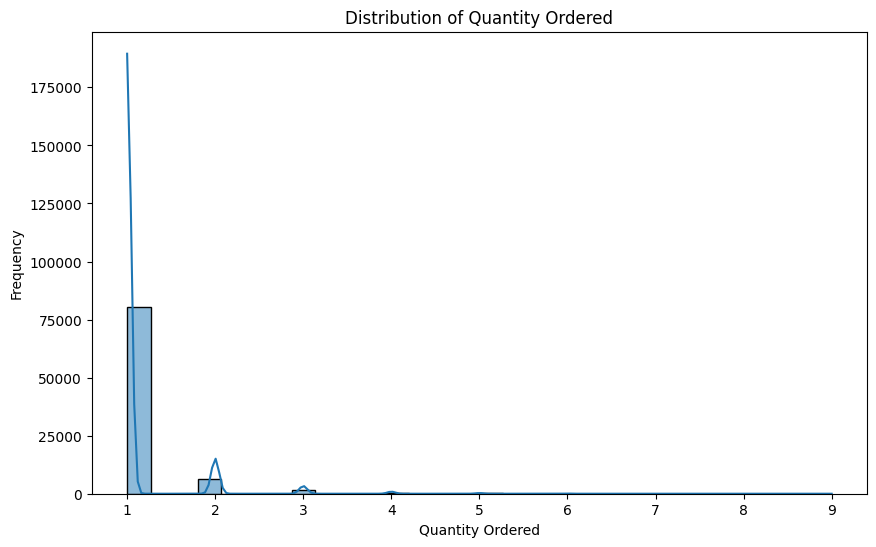

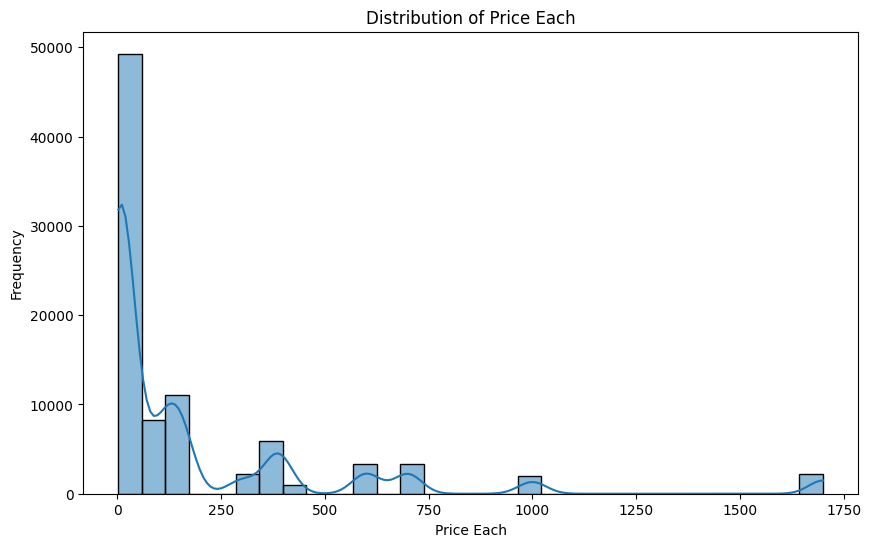

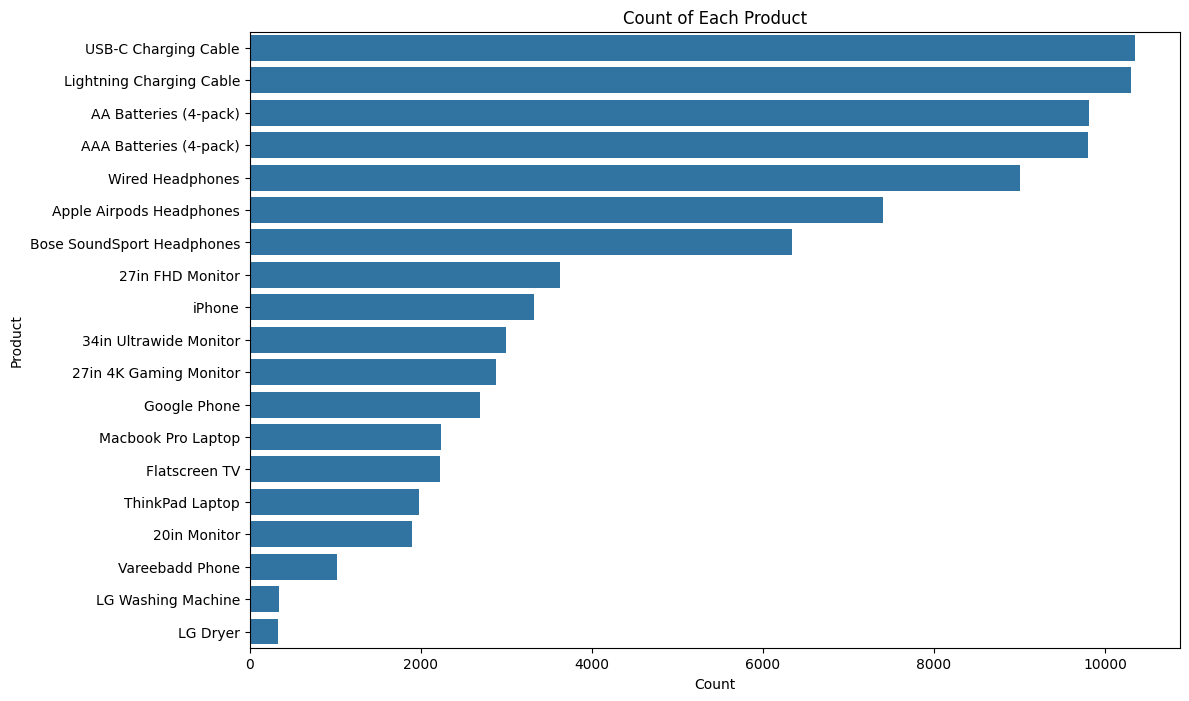

In [17]:
# Distribution of Quantity Ordered
plt.figure(figsize=(10, 6))
sns.histplot(df_2019['Quantity_Ordered'], bins=30, kde=True)
plt.title('Distribution of Quantity Ordered')
plt.xlabel('Quantity Ordered')
plt.ylabel('Frequency')
plt.show()

# Distribution of Price Each
plt.figure(figsize=(10, 6))
sns.histplot(df_2019['Price_Each'], bins=30, kde=True)
plt.title('Distribution of Price Each')
plt.xlabel('Price Each')
plt.ylabel('Frequency')
plt.show()

# Count of each product
plt.figure(figsize=(12, 8))
sns.countplot(y='Product', data=df_2019, order=df_2019['Product'].value_counts().index)
plt.title('Count of Each Product')
plt.xlabel('Count')
plt.ylabel('Product')
plt.show()


### Observations

* Distribution of Quantity Ordered

The distribution is highly skewed towards a quantity of 1, with the vast majority of orders being single-item purchases.
There is a steep drop in the frequency for quantities above 2, indicating that customers rarely order more than one or two items per transaction.
This suggests that the typical buying behavior is focused on small, individual purchases rather than bulk buying.

* Distribution of Price Each

The price distribution shows a concentration of sales at lower price points, with a peak below $250.
There are several smaller peaks at higher price ranges, but the overall frequency decreases significantly as the price increases.
This implies that more affordable items are driving the majority of sales, with fewer purchases for higher-priced items.

* Count of Each Product

The most commonly sold items are USB-C Charging Cables, Lightning Charging Cables, and AA and AAA batteries, all of which are relatively low-cost, everyday items.
High-end products like monitors, laptops, and phones have lower sales volumes compared to accessories like charging cables and batteries.
This further reinforces the insight that lower-cost, frequently needed items are driving the majority of sales.

## Bivariate Analysis

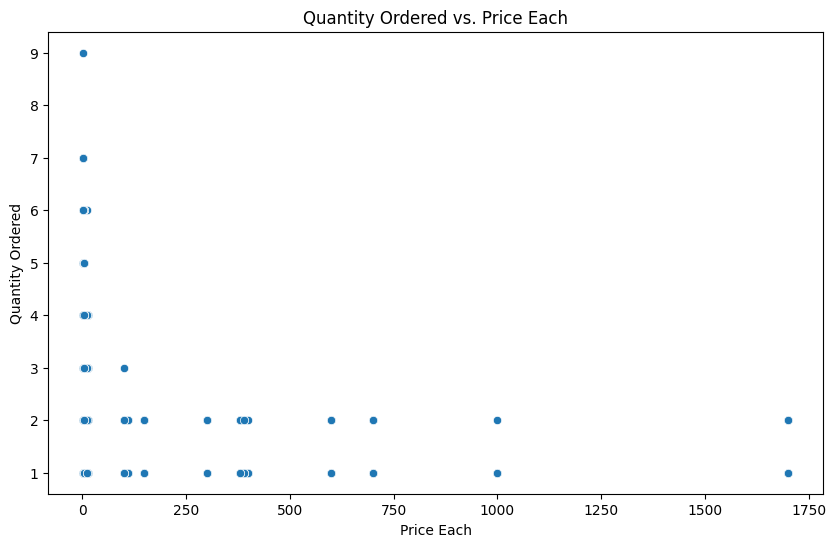

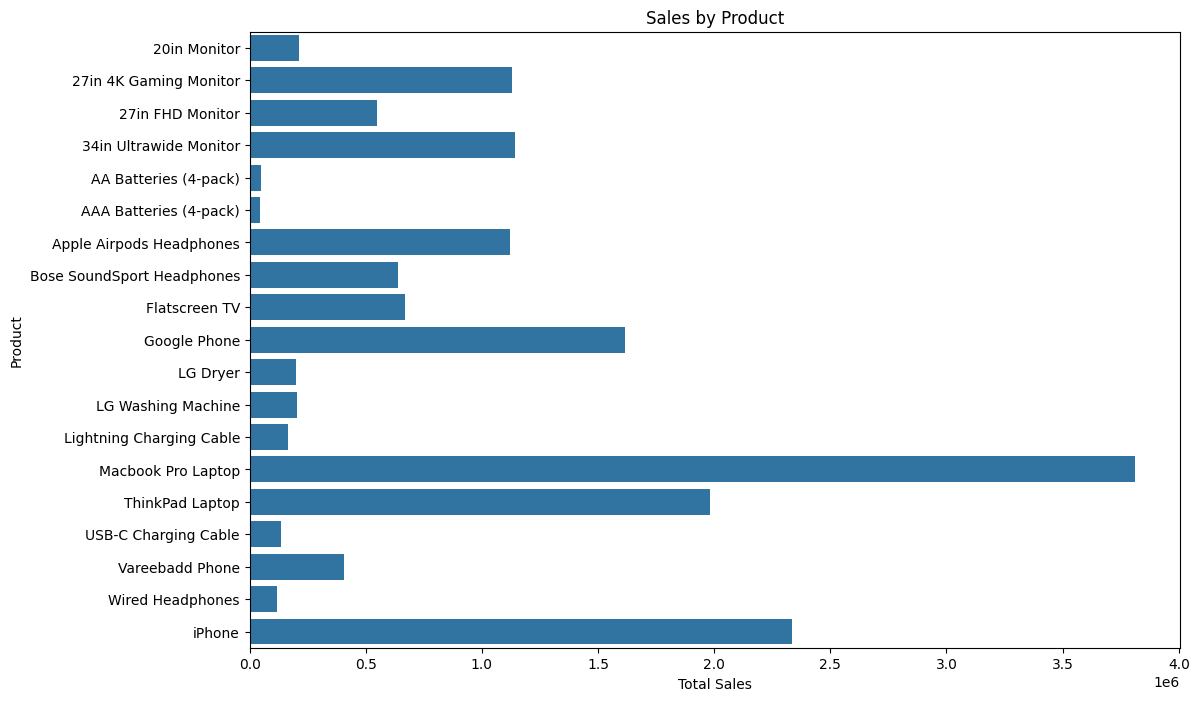

In [18]:
# Relationship between Quantity Ordered and Price Each
# #Scatter plot of Quantity Ordered vs. Price Each
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price_Each', y='Quantity_Ordered', data=df_2019)
plt.title('Quantity Ordered vs. Price Each')
plt.xlabel('Price Each')
plt.ylabel('Quantity Ordered')
plt.show()


# To analyze the relationship between unit price and sales volume, you need to compute the Sales, which is Quantity_Ordered multiplied by Price_Each.
# Sales by Product
# Calculate sales for each product
df_2019['Sales'] = df_2019['Quantity_Ordered'] * df_2019['Price_Each']

# Plot sales by product
plt.figure(figsize=(12, 8))
sns.barplot(x='Sales', y='Product', data=df_2019.groupby('Product')['Sales'].sum().reset_index())
plt.title('Sales by Product')
plt.xlabel('Total Sales')
plt.ylabel('Product')
plt.show()


### Observations
* Quantity Ordered vs. Price Each

There's a general negative correlation between price and quantity ordered.
Lower-priced items (under $250) have a wide range of order quantities, from 1 to 9 units.
As the price increases, the maximum quantity ordered tends to decrease.
There are some high-priced items (around $1500-1750) that still have orders of 1-2 units.

* Sales by Product

The Macbook Pro Laptop has the highest sales, followed by the iPhone.
Electronic devices (laptops, phones, monitors) generally have higher sales than accessories.
The 27in 4K Gaming Monitor and 34in Ultrawide Monitor have significant sales, indicating a demand for high-end displays.
Lower-priced items like batteries and cables have the lowest sales figures.

### Multivariate Analysis

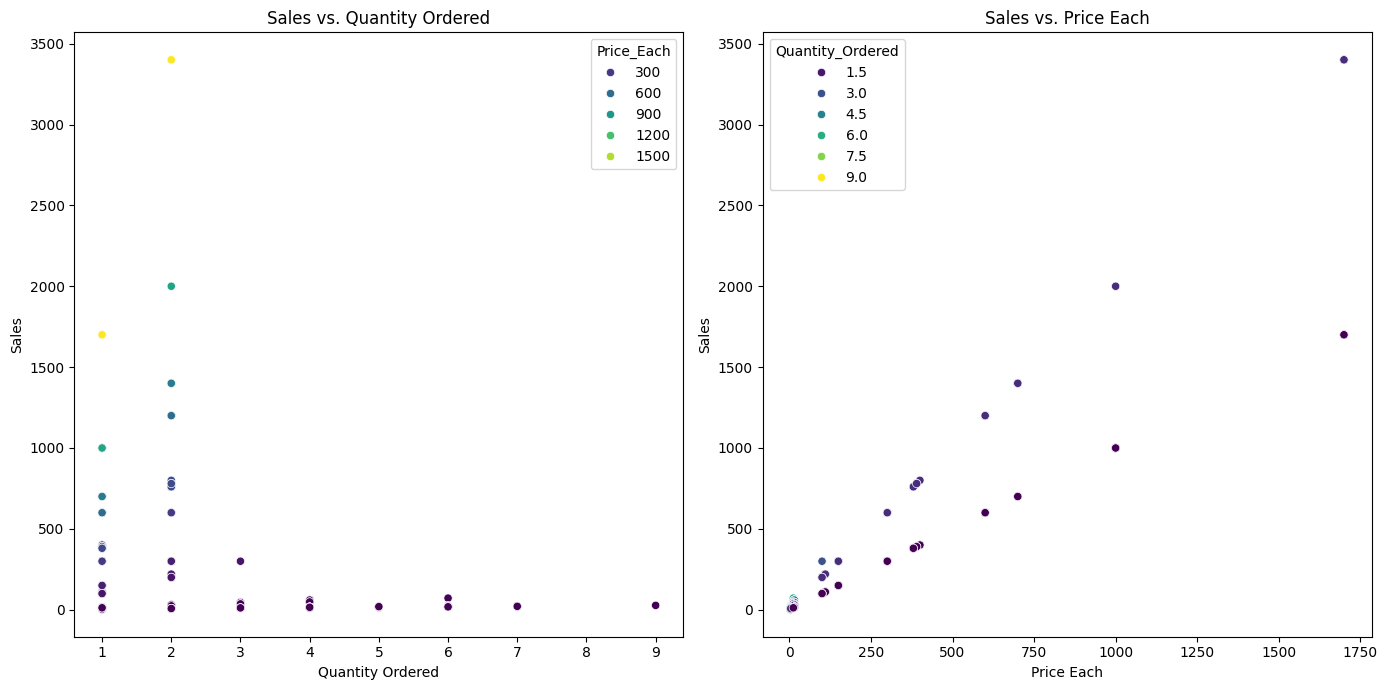

In [19]:
# Relationship between Sales, Quantity Ordered, and Price Each

# Plot sales vs. quantity ordered and price each
plt.figure(figsize=(14, 7))

# Scatter plot of Sales vs. Quantity Ordered
plt.subplot(1, 2, 1)
sns.scatterplot(x='Quantity_Ordered', y='Sales', data=df_2019, hue='Price_Each', palette='viridis')
plt.title('Sales vs. Quantity Ordered')
plt.xlabel('Quantity Ordered')
plt.ylabel('Sales')

# Scatter plot of Sales vs. Price Each
plt.subplot(1, 2, 2)
sns.scatterplot(x='Price_Each', y='Sales', data=df_2019, hue='Quantity_Ordered', palette='viridis')
plt.title('Sales vs. Price Each')
plt.xlabel('Price Each')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()


### Observation
Sales vs. Quantity Ordered and Sales vs. Price Each

These two scatter plots provide additional insights:

* (Sales vs. Quantity Ordered):

There's a slight positive correlation between quantity ordered and sales.
Higher-priced items (represented by warmer colors) tend to have higher sales even at lower quantities.


* (Sales vs. Price Each):

There's a strong positive correlation between price and sales.
As the price increases, the sales amount generally increases.
The quantity ordered (represented by dot size) doesn't seem to have as strong an impact on sales as the price does.

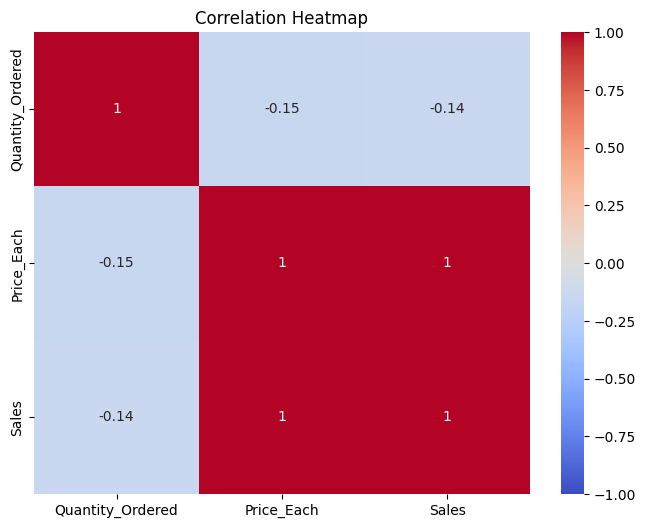

In [20]:
# Calculate correlations
correlation_matrix = df_2019[['Quantity_Ordered', 'Price_Each', 'Sales']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


### Observation
* This heatmap shows the correlations between Quantity Ordered, Price Each, and Sales

There's a perfect positive correlation (1.0) between Price Each and Sales, indicating that price is the primary driver of sales.
There's a weak negative correlation (-0.15) between Quantity Ordered and Price Each, confirming the observation from the graph "Quantity Ordered vs. Price Each" that higher-priced items tend to be ordered in smaller quantities.
There's a weak negative correlation (-0.14) between Quantity Ordered and Sales, suggesting that the number of items ordered has less impact on overall sales than their individual prices.

## Hypothesis Testing

* Null Hypothesis (H0): There is no significant relationship between unit price and sales.

* Alternative Hypothesis (H1): There is a significant relationship between unit price and sales.

Data Preparation

In [21]:
# Display the first few rows of the dataset to check its structure
df_2019.head()


,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
2,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
5,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


In [22]:
df_2019.shape


(88592, 7)

In [23]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88592 entries, 0 to 186848
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order_ID          88592 non-null  object        
 1   Product           88592 non-null  object        
 2   Quantity_Ordered  88592 non-null  float64       
 3   Price_Each        88592 non-null  float64       
 4   Order_Date        88592 non-null  datetime64[ns]
 5   Purchase_Address  88592 non-null  object        
 6   Sales             88592 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 5.4+ MB


In [24]:
df_2019.describe()

,Quantity_Ordered,Price_Each,Order_Date,Sales
count,88592.000000,88592.000000,88592,88592.000000
mean,1.124898,185.405753,2019-04-15 01:32:07.216227328,186.524734
min,1.000000,2.990000,2019-01-01 03:07:00,2.990000
25%,1.000000,11.950000,2019-03-02 05:32:45,11.950000
50%,1.000000,14.950000,2019-04-13 11:35:30,14.950000
75%,1.000000,150.000000,2019-05-22 10:13:30,150.000000
max,9.000000,1700.000000,2019-12-19 23:56:00,3400.000000
std,0.439587,333.000808,NaN,333.462881


In [25]:
# Check for duplicate Order_ID values
df_2019[df_2019.duplicated(subset=['Order_ID'], keep=False)]



,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
18,176574,Google Phone,1.0,600.00,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",600.00
19,176574,USB-C Charging Cable,1.0,11.95,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",11.95
30,176585,Bose SoundSport Headphones,1.0,99.99,2019-04-07 11:31:00,"823 Highland St, Boston, MA 02215",99.99
...,...,...,...,...,...,...,...
181980,254686.0,Lightning Charging Cable,1.0,14.95,2019-09-19 20:36:00,"285 Elm St, New York City, NY 10001",14.95
183046,255705.0,USB-C Charging Cable,1.0,11.95,2019-09-19 22:09:00,"7 Elm St, Atlanta, GA 30301",11.95
183047,255705.0,Apple Airpods Headphones,1.0,150.00,2019-09-19 22:09:00,"7 Elm St, Atlanta, GA 30301",150.00
186476,259006.0,Google Phone,1.0,600.00,2019-09-19 10:30:00,"494 11th St, New York City, NY 10001",600.00


In [26]:
# confirm changes
df_2019.isnull().sum()

Order_ID            0
Product             0
Quantity_Ordered    0
Price_Each          0
Order_Date          0
Purchase_Address    0
Sales               0
dtype: int64

### Add a new column for Product Level

In [27]:
# Create a new column 'Product_Level' based on Price_Each
df_2019['Product_Level'] = df_2019['Price_Each'].apply(lambda x: 'High-Level' if x > 99.99 else 'Basic Level')

# Display the first few rows to verify
print(df_2019.head())

# Count the number of products in each level
product_level_counts = df_2019['Product_Level'].value_counts()
print("Product Level Counts:\n", product_level_counts)


  Order_ID                     Product  Quantity_Ordered  Price_Each  \
0   176558        USB-C Charging Cable               2.0       11.95   
2   176559  Bose SoundSport Headphones               1.0       99.99   
3   176560                Google Phone               1.0      600.00   
4   176560            Wired Headphones               1.0       11.99   
5   176561            Wired Headphones               1.0       11.99   

           Order_Date                      Purchase_Address   Sales  \
0 2019-04-19 08:46:00          917 1st St, Dallas, TX 75001   23.90   
2 2019-04-07 22:30:00     682 Chestnut St, Boston, MA 02215   99.99   
3 2019-04-12 14:38:00  669 Spruce St, Los Angeles, CA 90001  600.00   
4 2019-04-12 14:38:00  669 Spruce St, Los Angeles, CA 90001   11.99   
5 2019-04-30 09:27:00     333 8th St, Los Angeles, CA 90001   11.99   

  Product_Level  
0   Basic Level  
2   Basic Level  
3    High-Level  
4   Basic Level  
5   Basic Level  
Product Level Counts:
 Product_L

In [28]:
df_2019

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Product_Level
0,176558,USB-C Charging Cable,2.0,11.950000,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.900000,Basic Level
2,176559,Bose SoundSport Headphones,1.0,99.990000,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.990000,Basic Level
3,176560,Google Phone,1.0,600.000000,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.000000,High-Level
4,176560,Wired Headphones,1.0,11.990000,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.990000,Basic Level
5,176561,Wired Headphones,1.0,11.990000,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.990000,Basic Level
...,...,...,...,...,...,...,...,...
186717,259235.0,Bose SoundSport Headphones,1.0,99.989998,2019-09-19 10:25:00,"590 Sunset St, Seattle, WA 98101",99.989998,Basic Level
186771,259286.0,AA Batteries (4-pack),2.0,3.840000,2019-09-19 18:03:00,"242 Center St, Seattle, WA 98101",7.680000,Basic Level
186823,259333.0,Bose SoundSport Headphones,1.0,99.989998,2019-09-19 18:03:00,"347 Ridge St, San Francisco, CA 94016",99.989998,Basic Level
186828,259337.0,USB-C Charging Cable,1.0,11.950000,2019-09-19 17:34:00,"495 Park St, Boston, MA 02215",11.950000,Basic Level


In [29]:
# Round 'Sales' and 'Price_Each' to 2 decimal places
df_2019['Sales'] = df_2019['Sales'].round(2)
df_2019['Price_Each'] = df_2019['Price_Each'].round(2)

# Check the result
df_2019.head()


,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Product_Level
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,Basic Level
2,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,Basic Level
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,High-Level
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,Basic Level
5,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,Basic Level


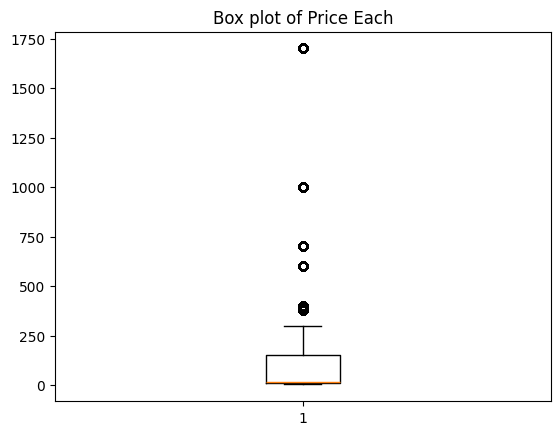

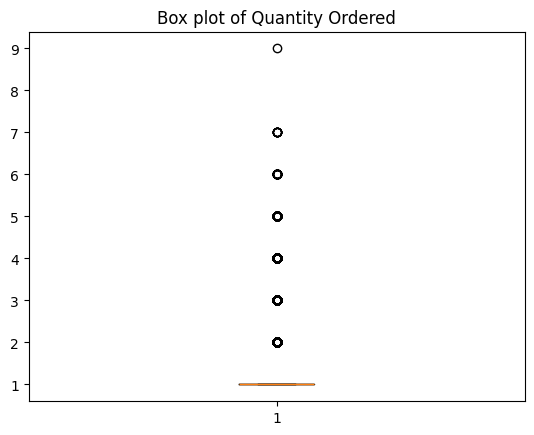

In [30]:
# Check and handle outliers if necessary.

# Box plot for Price_Each
plt.boxplot(df_2019['Price_Each'])
plt.title('Box plot of Price Each')
plt.show()

# Box plot for Quantity_Ordered
plt.boxplot(df_2019['Quantity_Ordered'])
plt.title('Box plot of Quantity Ordered')
plt.show()


Box Plot of Price Each
   - The median price (represented by the line in the box) is relatively low, likely around $50-100.
   - There's a wide range of prices, with the box (representing the interquartile range) extending to about $200.
   - There are many outliers above the upper whisker, indicated by individual points.
   - Some extreme outliers exist at prices around $750, $1000, and $1750.
   - The distribution is heavily right-skewed, with most items priced low but a few very expensive items.

Quantity Ordered
   - The median quantity ordered is 1, as shown by the single line at the bottom of the plot.
   - The box is compressed into this line, indicating that at least 75% of orders are for a single item.
   - There are multiple outliers, with some orders reaching quantities of 2, 3, 4, 5, 6, 7, and even 9 items.
   - The distribution is extremely right-skewed, with most orders being for single items but occasional bulk orders.

In [31]:
# Check for any remaining missing values
print(df_2019.isnull().sum())

Order_ID            0
Product             0
Quantity_Ordered    0
Price_Each          0
Order_Date          0
Purchase_Address    0
Sales               0
Product_Level       0
dtype: int64


In [32]:
# save the cleaned and prepared dataframe for further analysis:

df_2019.to_csv('data_2019.csv', index=False)


In [33]:
# Calculate Pearson correlation
corr, _ = pearsonr(df_2019['Price_Each'], df_2019['Sales'])
print(f"Pearson Correlation Coefficient: {corr:.2f}")

# Interpret the result
if abs(corr) > 0.5:
    print("We reject the Null Hypothesis and state that, there is a significant relationship between unit price and sales price.")
else:
    print("We accpept the Null Hypothesis that, there is no significant relationship between unit price and sales price.")


Pearson Correlation Coefficient: 1.00
We reject the Null Hypothesis and state that, there is a significant relationship between unit price and sales price.


Just to be sure we also used the  Linear Regression to further understand the impact of unit price on sales and quantify the relationship and analyse our hypothesis 

In [34]:

# Define independent and dependent variables
X = df_2019[['Price_Each']]
y = df_2019['Sales']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.071e+07
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:53:26   Log-Likelihood:            -3.6874e+05
No. Observations:               88592   AIC:                         7.375e+05
Df Residuals:                   88590   BIC:                         7.375e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0634      0.060     17.797      0.0

### Analysis
Coefficient for Price_Each: 0.9998

P-value for Price_Each: 0.000

The p-value for the Price_Each coefficient is 0.000, which is well below the common significance level of 0.05. This indicates that the relationship between Price_Each and Sales_Volume is statistically significant.


* Reject the Null Hypothesis (H0): The p-value is much less than 0.05, so we reject the null hypothesis. This suggests that there is a significant relationship between unit price and sales volume.

The statistical analysis strongly indicates that unit price does indeed have a significant relationship with sales volume. Therefore, we reject the null hypothesis and accept the alternative hypothesis that there is a significant relationship between the two variables.

This means that changes in unit price are significantly associated with changes in sales volume, according to this regression model.


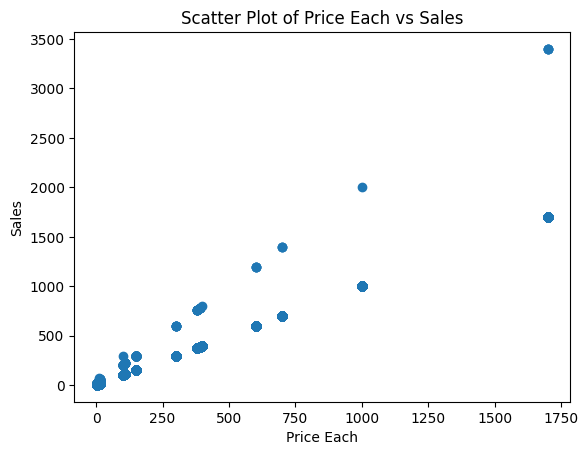

In [35]:

# Scatter plot of Price_Each vs Sales
plt.scatter(df_2019['Price_Each'], df_2019['Sales'])
plt.xlabel('Price Each')
plt.ylabel('Sales')
plt.title('Scatter Plot of Price Each vs Sales')
plt.show()


### Observation
Positive correlation: 
There's a clear positive correlation between the price of items and their sales volume. As the price increases, the sales volume tends to increase as well.

Price range: 
The products range in price from near $0 to about $1750, indicating a diverse product lineup.

Sales volume range: 
Sales volumes vary from very low (near 0) to around 3500 units.

Clustering: 
There's a cluster of lower-priced items (below $250) with relatively low sales volumes, suggesting many affordable products that sell in smaller quantities.

High-value items: 
There are several high-priced items (above $1000) that generate significant sales volumes, possibly representing premium products or big-ticket items.

Outliers: 
A few items stand out, particularly one priced around $1000 with sales of about 2000 units, and another priced at about $1750 with sales of about 3400 units. These could be popular flagship products.



## Analytical Questions

### 1. How much money did we make this year? 

In [36]:
# To calculate the total revenue for the year, you need to sum up the sales for all transactions.

# Calculate total revenue
# df_2019['Sales'] = df_2019['Quantity_Ordered'] * df_2019['Price_Each']

total_revenue = df_2019['Sales'].sum()
print(f"Total Revenue for the Year: ${total_revenue:.2f}")


Total Revenue for the Year: $16524599.21


### 2. Can we identify any seasonality in the sales? 

In [37]:
print(df_2019.columns)


Index(['Order_ID', 'Product', 'Quantity_Ordered', 'Price_Each', 'Order_Date',
       'Purchase_Address', 'Sales', 'Product_Level'],
      dtype='object')


In [38]:
# Ensure 'Order_Date' is in datetime format
df_2019['Order_Date'] = pd.to_datetime(df_2019['Order_Date'])  

# Extract the month
df_2019['Month'] = df_2019['Order_Date'].dt.month  


Data types before conversion:
Month      int32
Sales    float64
dtype: object
Unique values in 'Month':
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12']
Data types after conversion:
Month     object
Sales    float64
dtype: object


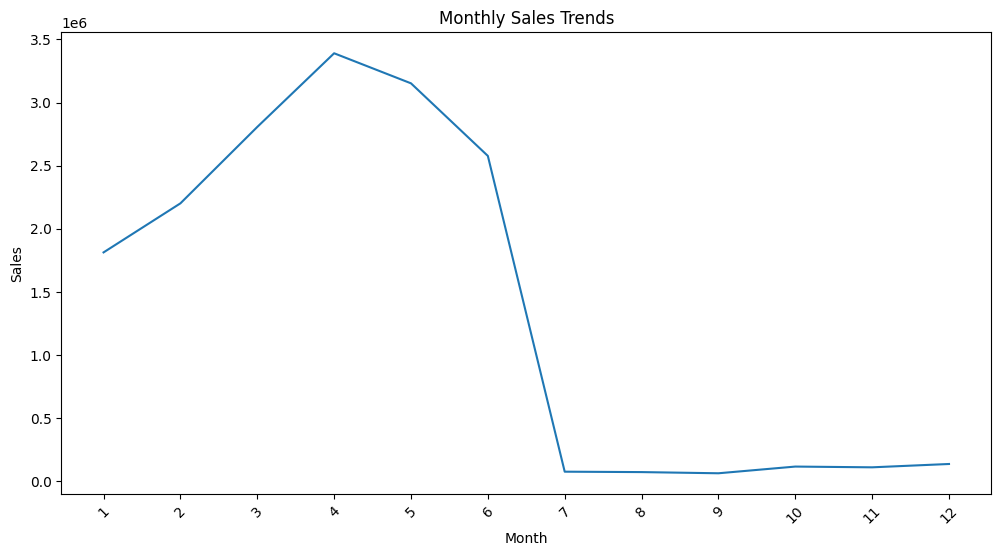

In [39]:
# Aggregate sales by month
monthly_sales = df_2019.groupby('Month')['Sales'].sum().reset_index()


# Check the data types of the columns
print("Data types before conversion:")
print(monthly_sales.dtypes)

# Convert 'Sales' column to numeric, coercing errors to NaN
monthly_sales['Sales'] = pd.to_numeric(monthly_sales['Sales'], errors='coerce')


# fill NaN values with 0
monthly_sales['Sales'].fillna(0, inplace=True)

# Drop rows where 'Sales' is NaN
# monthly_sales.dropna(subset=['Sales'], inplace=True)

# Ensure 'Month' column is in the correct format (string or datetime)
# Convert 'Month' to string if it's not already
monthly_sales['Month'] = monthly_sales['Month'].astype(str)

# Print unique values to check if 'Month' has unexpected values
print("Unique values in 'Month':")
print(monthly_sales['Month'].unique())

# Ensure columns exist and contain proper data types
if 'Month' in monthly_sales.columns and 'Sales' in monthly_sales.columns:
    # Verify the data types again
    print("Data types after conversion:")
    print(monthly_sales.dtypes)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Month', y='Sales', data=monthly_sales)
    plt.title('Monthly Sales Trends')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.show()
else:
    print("Error: 'Month' and/or 'Sales' columns are missing in the DataFrame.")


The sales show a distinct pattern of growth followed by a sharp decline. This could be linked to COVID-19

### 3. What are our best and worst-selling products? 

In [40]:
# To find the best and worst-selling products, aggregate sales by product.

# Calculate total sales for each product
product_sales = df_2019.groupby('Product')['Sales'].sum().reset_index()

# Find best and worst-selling products
best_selling = product_sales.loc[product_sales['Sales'].idxmax()]
worst_selling = product_sales.loc[product_sales['Sales'].idxmin()]

print(f"Best-Selling Product: {best_selling['Product']} with Sales ${best_selling['Sales']:.2f}")
print(f"Worst-Selling Product: {worst_selling['Product']} with Sales ${worst_selling['Sales']:.2f}")


Best-Selling Product: Macbook Pro Laptop with Sales $3813100.00
Worst-Selling Product: AAA Batteries (4-pack) with Sales $43979.91


### 4.  How do sales compare to previous months or weeks? 

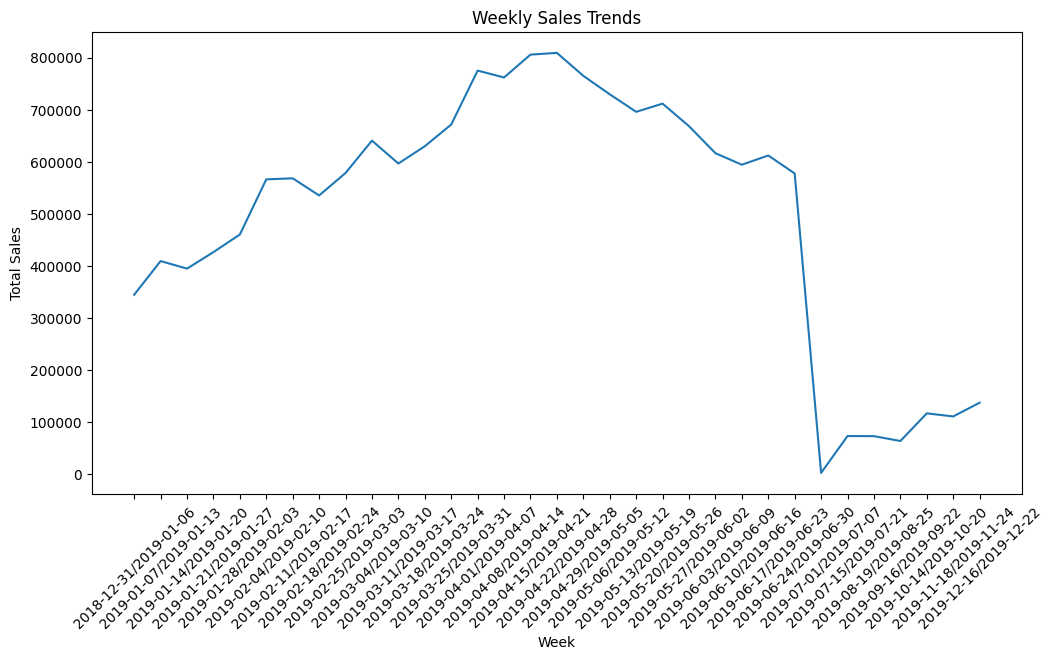

In [41]:
# Ensure Order_Date is a Datetime Type
# Making sure the Order_Date column is of datetime type
df_2019['Order_Date'] = pd.to_datetime(df_2019['Order_Date'])


# Correctly Convert Order_Date to Week Periods
# convert to weekly periods
df_2019['Week'] = df_2019['Order_Date'].dt.to_period('W')


# Aggregate Sales by Week
# aggregate correctly 
weekly_sales = df_2019.groupby('Week')['Sales'].sum().reset_index()
weekly_sales['Week'] = weekly_sales['Week'].astype(str)  # Convert period to string for plotting


# Plot Weekly Sales Trends
# plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='Week', y='Sales', data=weekly_sales)
plt.title('Weekly Sales Trends')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()



### 5. Which cities are our products delivered to most? 

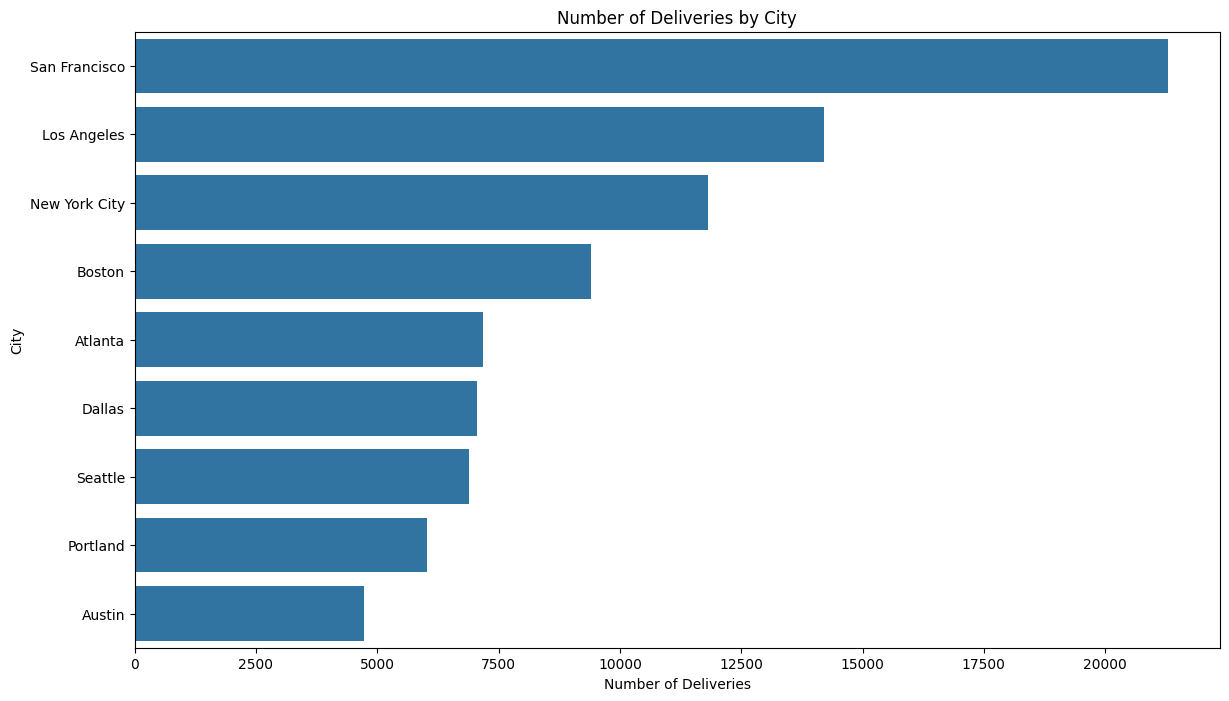

In [42]:
# To determine which cities have the most product deliveries, aggregate by city.
# Extract city from Purchase_Address
df_2019['City'] = df_2019['Purchase_Address'].apply(lambda x: x.split(',')[1].strip())

# Count deliveries by city
city_deliveries = df_2019['City'].value_counts().reset_index()
city_deliveries.columns = ['City', 'Number of Deliveries']

# Plot number of deliveries by city
plt.figure(figsize=(14, 8))
sns.barplot(x='Number of Deliveries', y='City', data=city_deliveries)
plt.title('Number of Deliveries by City')
plt.xlabel('Number of Deliveries')
plt.ylabel('City')
plt.show()


In [43]:
df_2019.head()

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Product_Level,Month,Week,City
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,Basic Level,4,2019-04-15/2019-04-21,Dallas
2,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,Basic Level,4,2019-04-01/2019-04-07,Boston
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,High-Level,4,2019-04-08/2019-04-14,Los Angeles
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,Basic Level,4,2019-04-08/2019-04-14,Los Angeles
5,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,Basic Level,4,2019-04-29/2019-05-05,Los Angeles


### 6. How do product categories compare in revenue generated and quantities ordered? 

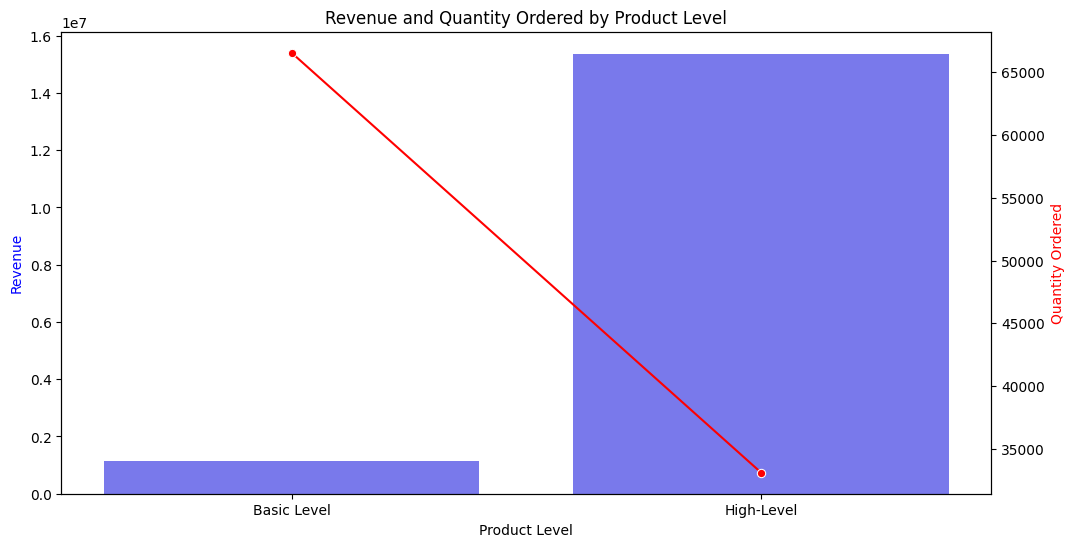

In [44]:
# Label the products as high-level or basic level, then compare the revenues and quantities.
# Label products
# df_2019['Product_Level'] = df_2019['Price_Each'].apply(lambda x: 'High-Level' if x > 99.99 else 'Basic')

# Aggregate revenue and quantities by product level
category_comparison = df_2019.groupby('Product_Level').agg({'Sales': 'sum', 'Quantity_Ordered': 'sum'}).reset_index()

# Plot revenue and quantities
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
sns.barplot(x='Product_Level', y='Sales', data=category_comparison, ax=ax1, color='blue', alpha=0.6)
sns.lineplot(x='Product_Level', y='Quantity_Ordered', data=category_comparison, ax=ax2, color='red', marker='o')

ax1.set_ylabel('Revenue', color='blue')
ax2.set_ylabel('Quantity Ordered', color='red')
ax1.set_xlabel('Product Level')
ax1.set_title('Revenue and Quantity Ordered by Product Level')

plt.show()


In [45]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88592 entries, 0 to 186848
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order_ID          88592 non-null  object        
 1   Product           88592 non-null  object        
 2   Quantity_Ordered  88592 non-null  float64       
 3   Price_Each        88592 non-null  float64       
 4   Order_Date        88592 non-null  datetime64[ns]
 5   Purchase_Address  88592 non-null  object        
 6   Sales             88592 non-null  float64       
 7   Product_Level     88592 non-null  object        
 8   Month             88592 non-null  int32         
 9   Week              88592 non-null  period[W-SUN] 
 10  City              88592 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(1), object(5), period[W-SUN](1)
memory usage: 7.8+ MB


### 7. You are required to show additional details from your findings in your data. 
Further Findings

In [46]:
df_2019.head(7)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Product_Level,Month,Week,City
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,Basic Level,4,2019-04-15/2019-04-21,Dallas
2,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,Basic Level,4,2019-04-01/2019-04-07,Boston
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,High-Level,4,2019-04-08/2019-04-14,Los Angeles
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,Basic Level,4,2019-04-08/2019-04-14,Los Angeles
5,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,Basic Level,4,2019-04-29/2019-05-05,Los Angeles
6,176562,USB-C Charging Cable,1.0,11.95,2019-04-29 13:03:00,"381 Wilson St, San Francisco, CA 94016",11.95,Basic Level,4,2019-04-29/2019-05-05,San Francisco
7,176563,Bose SoundSport Headphones,1.0,99.99,2019-04-02 07:46:00,"668 Center St, Seattle, WA 98101",99.99,Basic Level,4,2019-04-01/2019-04-07,Seattle


#### Sales Distribution
Visualize the distribution of sales values to understand the spread.

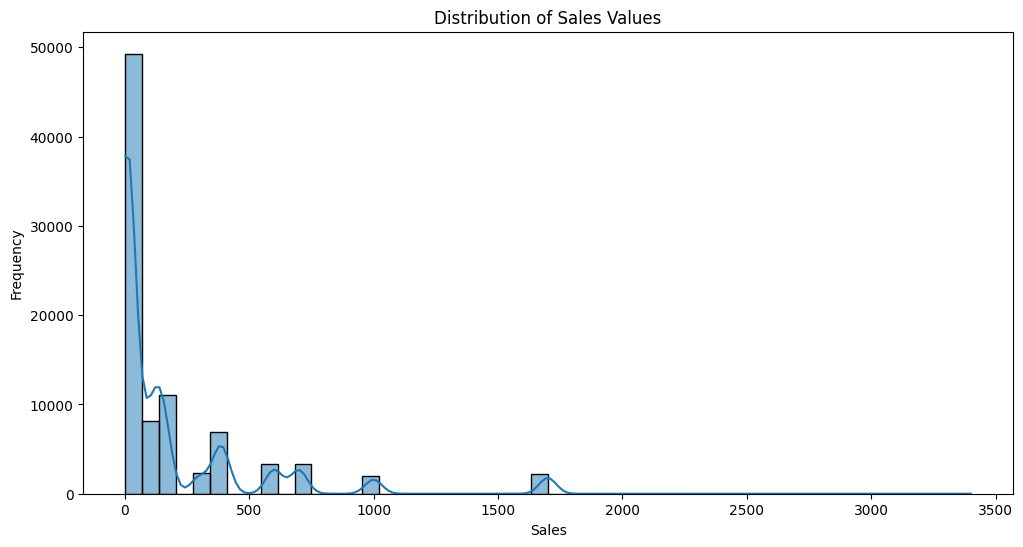

In [47]:
plt.figure(figsize=(12, 6))
sns.histplot(df_2019['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales Values')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


### Observation

Right-skewed distribution: 
The distribution of sales values is heavily right-skewed, with a long tail extending to higher sales values.

High frequency of low sales: 
There's a very high frequency of sales in the lowest range (near 0), suggesting many transactions involve low-cost items or small quantities.

Multiple peaks: 
The distribution shows several smaller peaks beyond the initial large peak, possibly indicating different product categories or price points that are popular.


Decreasing frequency: 
As the sales value increases, the frequency generally decreases, but not smoothly. There are several smaller spikes throughout the distribution.

Potential price points: 
The smaller peaks could represent common price points or popular product categories, such as around 500, 1000, and 1500.

### Top 10 Performing Products
Identify the top 10 performing products based on total sales and quantities ordered

Top 10 Products by Total Sales:
                                  Sales
Product                               
Macbook Pro Laptop          3813100.00
iPhone                      2333100.00
ThinkPad Laptop             1982980.17
Google Phone                1617600.00
34in Ultrawide Monitor      1141109.97
27in 4K Gaming Monitor      1127461.09
Apple Airpods Headphones    1119000.00
Flatscreen TV                670500.00
Bose SoundSport Headphones   638936.10
27in FHD Monitor             546263.58


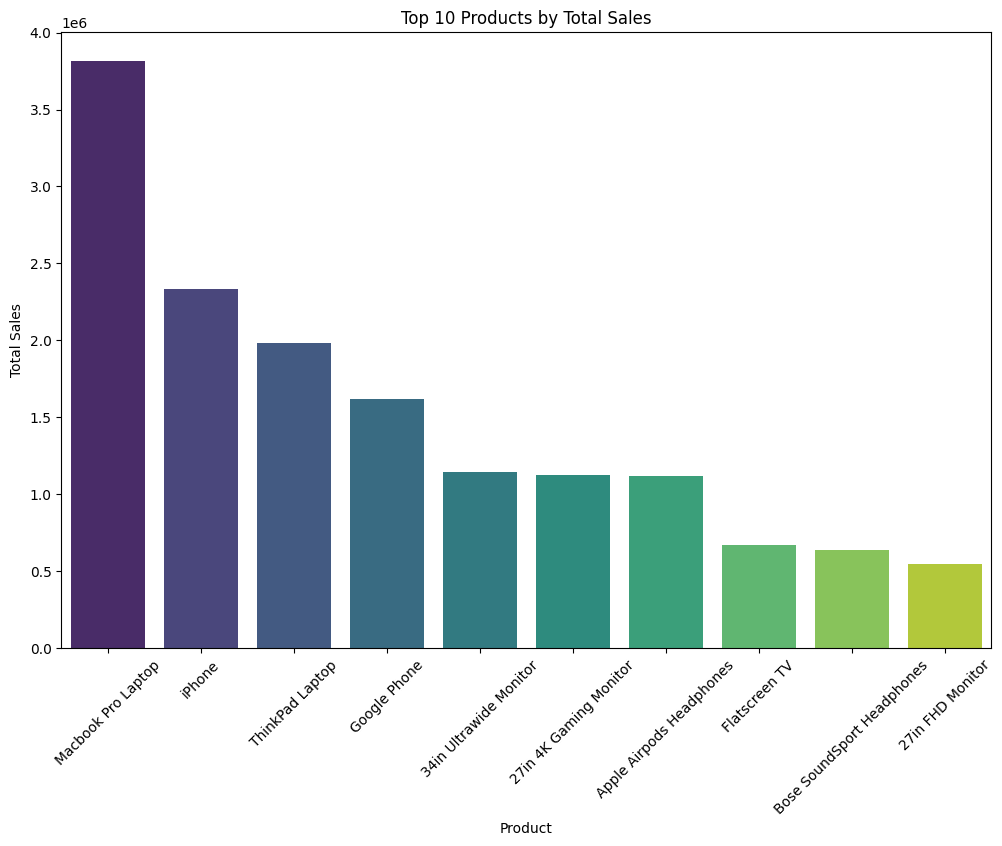

Top 10 Products by Quantity Ordered:
                             Quantity_Ordered
Product                                     
AAA Batteries (4-pack)               14709.0
AA Batteries (4-pack)                13221.0
USB-C Charging Cable                 11336.0
Lightning Charging Cable             11080.0
Wired Headphones                      9828.0
Apple Airpods Headphones              7460.0
Bose SoundSport Headphones            6390.0
27in FHD Monitor                      3642.0
iPhone                                3333.0
34in Ultrawide Monitor                3003.0


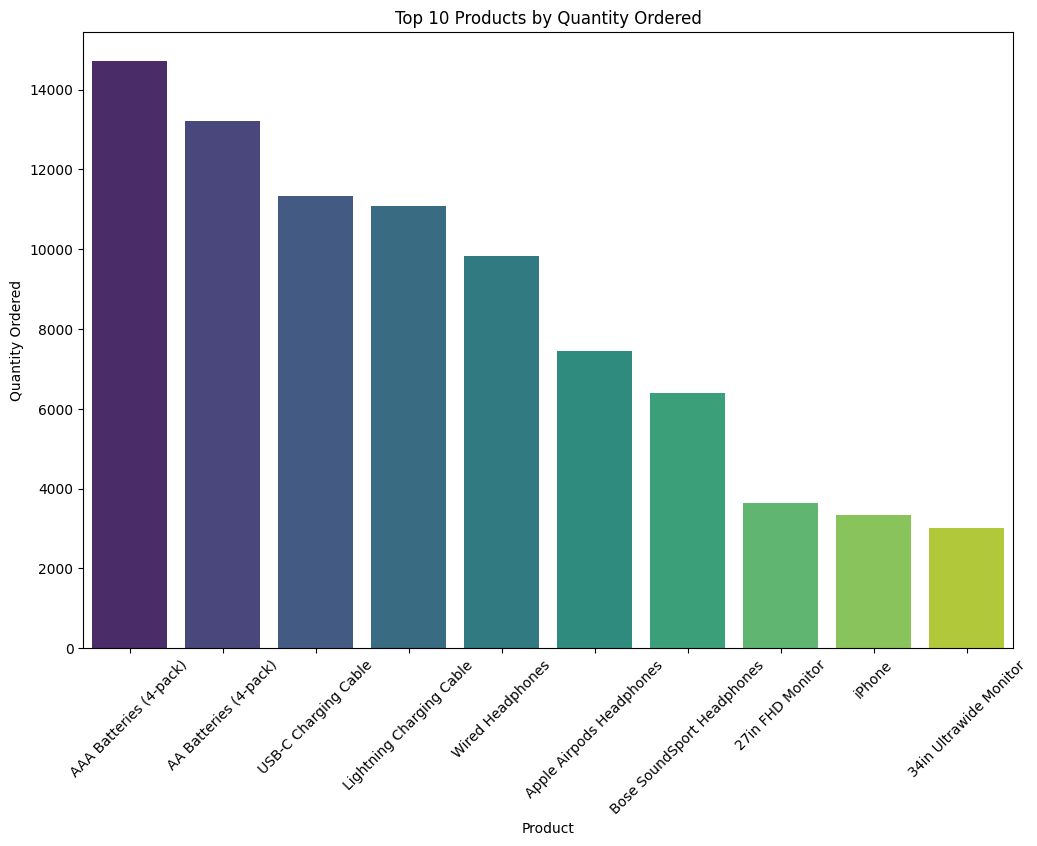

In [48]:
# Top 10 products by total sales
top_products_sales = df_2019.groupby('Product').agg({'Sales': 'sum'}).sort_values('Sales', ascending=False).head(10)
print("Top 10 Products by Total Sales:\n", top_products_sales)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_products_sales.index, y='Sales', data=top_products_sales, palette='viridis')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


# Top 10 products by quantity ordered
top_products_quantity = df_2019.groupby('Product').agg({'Quantity_Ordered': 'sum'}).sort_values('Quantity_Ordered', ascending=False).head(10)
print("Top 10 Products by Quantity Ordered:\n", top_products_quantity)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_products_quantity.index, y='Quantity_Ordered', data=top_products_quantity, palette='viridis')
plt.title('Top 10 Products by Quantity Ordered')
plt.xlabel('Product')
plt.ylabel('Quantity Ordered')
plt.xticks(rotation=45)
plt.show()



### Product_Level Distribution
Analyzing the distribution of sales and quantities for each Product_Level

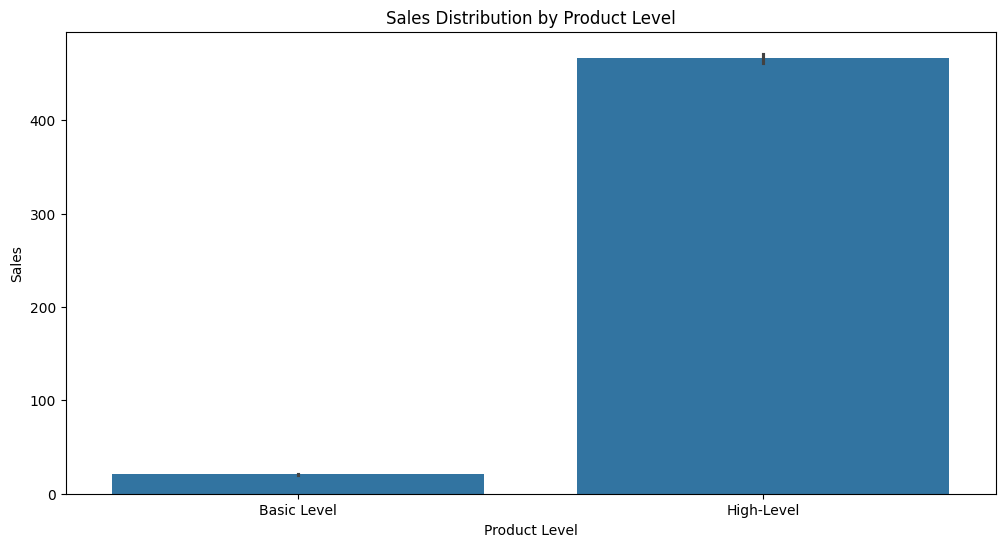

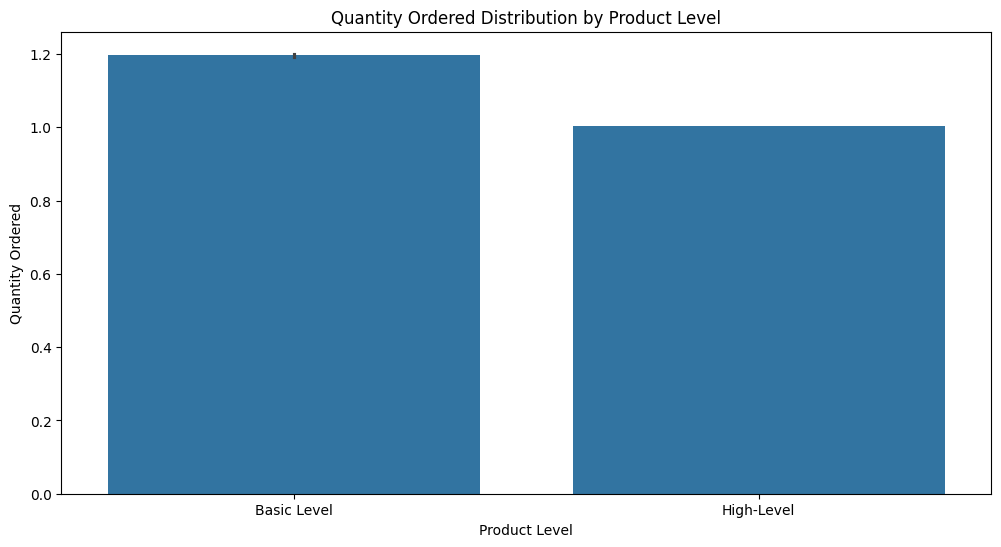

In [49]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Product_Level', y='Sales', data=df_2019)
plt.title('Sales Distribution by Product Level')
plt.xlabel('Product Level')
plt.ylabel('Sales')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Product_Level', y='Quantity_Ordered', data=df_2019)
plt.title('Quantity Ordered Distribution by Product Level')
plt.xlabel('Product Level')
plt.ylabel('Quantity Ordered')
plt.show()


Number of Products in the Product_Level Category

In [50]:
# Count the number of products in each product-level category
product_level_counts = df_2019['Product_Level'].value_counts()

# Print the counts
print("Product Level Counts:\n", product_level_counts)


Product Level Counts:
 Product_Level
Basic Level    55620
High-Level     32972
Name: count, dtype: int64


Analyze Average Price Frequency Based on Unit Price


In [51]:
# Calculate the average unit price for each product level
avg_price_per_level = df_2019.groupby('Product_Level')['Price_Each'].mean()

# Print the average prices
print("Average Price Per Product Level:\n", avg_price_per_level)


Average Price Per Product Level:
 Product_Level
Basic Level     19.532548
High-Level     465.214913
Name: Price_Each, dtype: float64


Frequency Distribution of Product_Level Based on Price_Each (Unit Price)

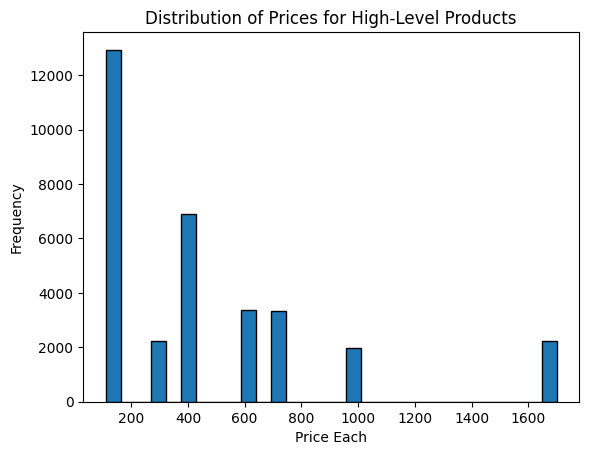

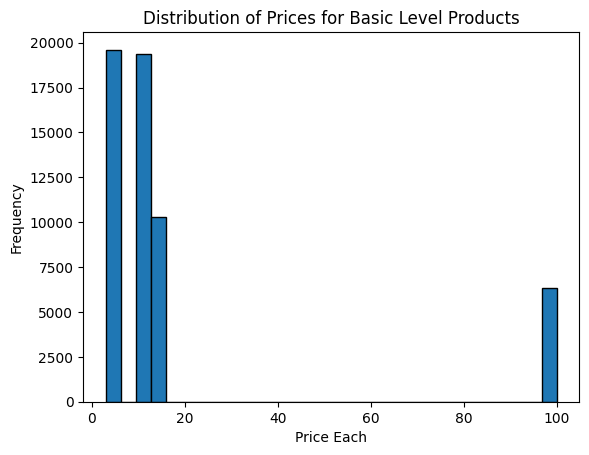

In [52]:
# Plot histogram for High-Level products
high_level_prices = df_2019[df_2019['Product_Level'] == 'High-Level']['Price_Each']
plt.hist(high_level_prices, bins=30, edgecolor='black')
plt.title('Distribution of Prices for High-Level Products')
plt.xlabel('Price Each')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for Basic Level products
basic_level_prices = df_2019[df_2019['Product_Level'] == 'Basic Level']['Price_Each']
plt.hist(basic_level_prices, bins=30, edgecolor='black')
plt.title('Distribution of Prices for Basic Level Products')
plt.xlabel('Price Each')
plt.ylabel('Frequency')
plt.show()


In [53]:
df_2019

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Product_Level,Month,Week,City
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,Basic Level,4,2019-04-15/2019-04-21,Dallas
2,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,Basic Level,4,2019-04-01/2019-04-07,Boston
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,High-Level,4,2019-04-08/2019-04-14,Los Angeles
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,Basic Level,4,2019-04-08/2019-04-14,Los Angeles
5,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,Basic Level,4,2019-04-29/2019-05-05,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...
186717,259235.0,Bose SoundSport Headphones,1.0,99.99,2019-09-19 10:25:00,"590 Sunset St, Seattle, WA 98101",99.99,Basic Level,9,2019-09-16/2019-09-22,Seattle
186771,259286.0,AA Batteries (4-pack),2.0,3.84,2019-09-19 18:03:00,"242 Center St, Seattle, WA 98101",7.68,Basic Level,9,2019-09-16/2019-09-22,Seattle
186823,259333.0,Bose SoundSport Headphones,1.0,99.99,2019-09-19 18:03:00,"347 Ridge St, San Francisco, CA 94016",99.99,Basic Level,9,2019-09-16/2019-09-22,San Francisco
186828,259337.0,USB-C Charging Cable,1.0,11.95,2019-09-19 17:34:00,"495 Park St, Boston, MA 02215",11.95,Basic Level,9,2019-09-16/2019-09-22,Boston


In [54]:
# Save df_2019 to CSV
df_2019.to_csv('df_2019.csv', index=False)


### Second Hypothesis Testing

* H0 (Null Hypothesis): There is no significant difference in average sales between different cities.
* H1 (Alternative Hypothesis): There is a significant difference in average sales between different cities.

In [55]:
# Perform ANOVA test to check if there's a significant difference in sales across cities
anova_results = stats.f_oneway(
    *[df_2019[df_2019['City'] == city]['Sales'] for city in df_2019['City'].unique()]
)

anova_results


F_onewayResult(statistic=np.float64(0.4718641072085699), pvalue=np.float64(0.8768350976422052))

The ANOVA test result shows that
* F-statistic: 0.472
* p-value: 0.877

The p-value is much greater than 0.05, indicating that there is no statistically significant difference in sales across different cities. Therefore, we fail to reject the null hypothesis that sales are similar across cities.

The ANOVA test performed indicates that there is no statistically significant difference in sales across different cities, as evidenced by a high p-value (0.877). This suggests that the observed variation in sales between cities is likely due to random chance rather than a systematic effect.

To summarize, the ANOVA result suggests that city location, by itself, does not have a statistically significant impact on sales, and therefore, there is no strong relationship between sales and cities in this dataset.

In [56]:
# Check the column names in the dataframe
print(df_2019.columns)


Index(['Order_ID', 'Product', 'Quantity_Ordered', 'Price_Each', 'Order_Date',
       'Purchase_Address', 'Sales', 'Product_Level', 'Month', 'Week', 'City'],
      dtype='object')
